Setup

In [ ]:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

Dataset Setup & Quick Audit

In [ ]:

URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [ ]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292

2) Handling Missing Values (Individually)

->Compare mean vs median imputation for Age

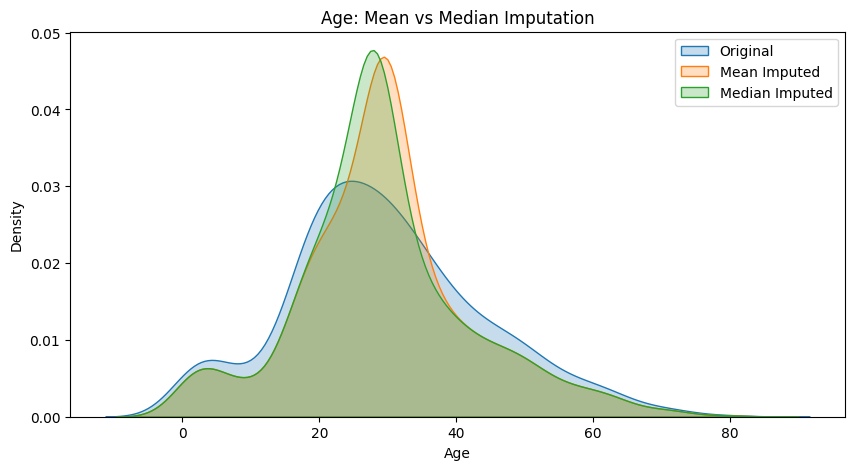

Original Age - Mean: 29.69911764705882  Median: 28.0
Mean Imputed - Mean: 29.69911764705882  Median: 29.69911764705882
Median Imputed - Mean: 29.36158249158249  Median: 28.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make copies
df_mean = df.copy()
df_median = df.copy()

# Fill Age with mean
df_mean['Age'] = df_mean['Age'].fillna(df['Age'].mean())

# Fill Age with median
df_median['Age'] = df_median['Age'].fillna(df['Age'].median())

# Compare distributions
plt.figure(figsize=(10,5))
sns.kdeplot(df['Age'], label="Original", fill=True)
sns.kdeplot(df_mean['Age'], label="Mean Imputed", fill=True)
sns.kdeplot(df_median['Age'], label="Median Imputed", fill=True)
plt.legend()
plt.title("Age: Mean vs Median Imputation")
plt.show()

# Compare statistics
print("Original Age - Mean:", df['Age'].mean(), " Median:", df['Age'].median())
print("Mean Imputed - Mean:", df_mean['Age'].mean(), " Median:", df_mean['Age'].median())
print("Median Imputed - Mean:", df_median['Age'].mean(), " Median:", df_median['Age'].median())


->For Embarked, try filling with a new category ('Unknown') vs mode.

In [ ]:
import pandas as pd

# Mode imputation
df_mode = df.copy()
df_mode['Embarked'] = df_mode['Embarked'].fillna(df['Embarked'].mode()[0])

# Unknown category imputation
df_unknown = df.copy()
df_unknown['Embarked'] = df_unknown['Embarked'].fillna("Unknown")

# Compare value counts
print("Original value counts (with NaN):")
print(df['Embarked'].value_counts(dropna=False), "\n")

print("Mode imputation value counts:")
print(df_mode['Embarked'].value_counts(), "\n")

print("'Unknown' imputation value counts:")
print(df_unknown['Embarked'].value_counts(), "\n")


Original value counts (with NaN):
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64 

Mode imputation value counts:
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64 

'Unknown' imputation value counts:
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64 



3)Scaling & Normalization (Individually)

 ->Standardize Fare and plot the histogram.

In [ ]:
import pandas as pd

# Load Titanic dataset
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)

# ---- Imputation to create df_imp ----
df_imp = df.copy()

# Age: fill with median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())

# Embarked: fill with most frequent (mode)
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# Cabin: fill with 'Unknown'
df_imp['Cabin'] = df_imp['Cabin'].fillna("Unknown")

print("Remaining nulls:\n", df_imp.isna().sum().head())



Shape: (891, 12)
Remaining nulls:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
dtype: int64


-> Apply Normalizer on [Age, Fare] rows and check the first 5 normalized vectors.

In [ ]:
import pandas as pd
from sklearn.preprocessing import Normalizer

# Select Age and Fare (after imputation, no nulls)
X = df_imp[['Age', 'Fare']]

# Apply row-wise Normalization
normalizer = Normalizer()
X_norm = normalizer.fit_transform(X)

# Convert back to DataFrame
X_norm_df = pd.DataFrame(X_norm, columns=['Age_norm', 'Fare_norm'])

# Show first 5 normalized vectors
print("First 5 normalized [Age, Fare] vectors:")
print(X_norm_df.head())


First 5 normalized [Age, Fare] vectors:
   Age_norm  Fare_norm
0  0.949757   0.312988
1  0.470417   0.882444
2  0.956551   0.291564
3  0.550338   0.834942
4  0.974555   0.224148


4) Encoding Categorical Variables (Individually)

->Compare the number of features produced by ordinal vs one-hot for Embarked.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# ---- Ordinal Encoding ----
ord_enc = OrdinalEncoder()
ord_embarked = ord_enc.fit_transform(df_imp[['Embarked']])
df_ord = pd.DataFrame(ord_embarked, columns=['Embarked_ord'])

# ---- One-Hot Encoding ----
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')

# ---- Compare feature counts ----
print("Unique Embarked categories:", df_imp['Embarked'].nunique())
print("Ordinal encoding -> features:", df_ord.shape[1])
print("One-Hot encoding -> features:", ohe_embarked.shape[1])

print("\nOrdinal encoding sample:")
print(df_ord.head())

print("\nOne-Hot encoding sample:")
print(ohe_embarked.head())



Unique Embarked categories: 3
Ordinal encoding -> features: 1
One-Hot encoding -> features: 3

Ordinal encoding sample:
   Embarked_ord
0           2.0
1           0.0
2           2.0
3           2.0
4           2.0

One-Hot encoding sample:
   Embarked_C  Embarked_Q  Embarked_S
0       False       False        True
1        True       False       False
2       False       False        True
3       False       False        True
4       False       False        True


->Why might one-hot be safer for linear models?

One-hot encoding is safer for linear models because it does not assume any order among categories. Ordinal encoding turns categories into numbers like 0, 1, 2, which makes the model think one category is larger or smaller than another, even when there is no real order. One-hot encoding avoids this by creating separate columns for each category, so the model treats them independently without adding a false ranking.

5) Feature Transformation (Individually)

->Identify one numeric column that is skewed. Try both log and power transforms and compare histograms.

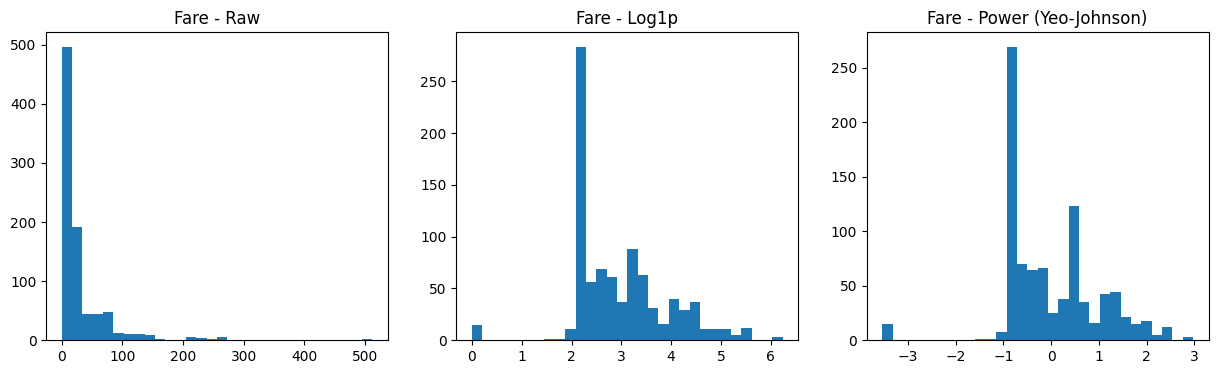

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PowerTransformer

# Choose a numeric column that is skewed: Fare
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)

# Log transform
fare_log = np.log1p(fare_raw)

# Power transform (Yeo-Johnson)
pt = PowerTransformer(method='yeo-johnson')
fare_power = pt.fit_transform(fare_raw)

# Compare histograms
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')

axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - Log1p')

axes[2].hist(fare_power.flatten(), bins=30)
axes[2].set_title('Fare - Power (Yeo-Johnson)')

plt.show()


-> With PolynomialFeatures(2), which new terms are created from Age and Fare?

Polynomial features create new variables by combining existing ones. With Age and Fare and degree set to 2, the new terms are (Age)², (Fare)², and (Age*Fare), in addition to the original Age and Fare. These new features allow linear models to capture simple non-linear patterns and interactions between variables.

6) Simple Dimensionality Reduction (PCA) — Visualization Only

-> Which two numeric columns contribute the most variance before PCA (use df.var())?

Explained variance ratios: [0.96165195 0.03587775]


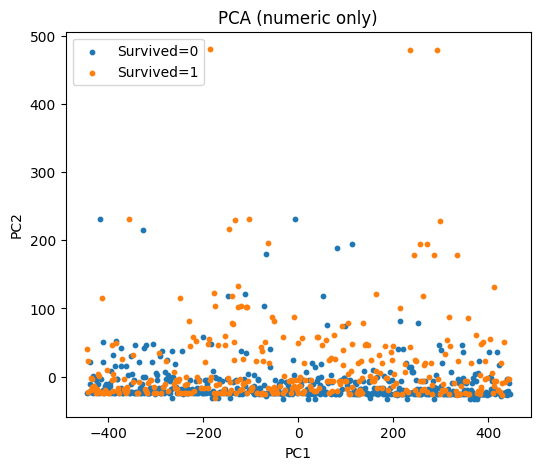

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Keep only numeric columns and drop NA
num_only = df_imp.select_dtypes(include=['number']).dropna()

# Get Survived column if it exists
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

# Apply PCA with 2 components
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Scatter plot
plt.figure(figsize=(6,5))
if y is not None:
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (numeric only)')
plt.show()


->Try PCA with n_components=3 and print the cumulative explained variance.

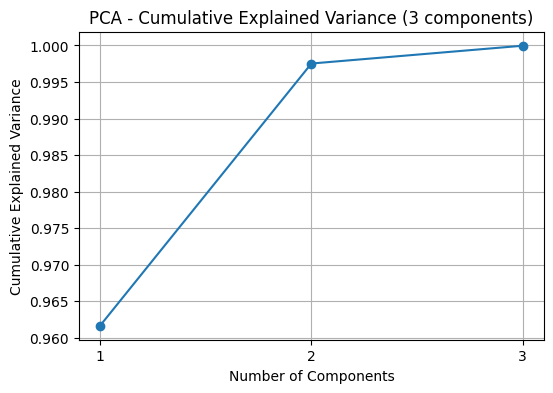

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Numeric data
num_only = df_imp.select_dtypes(include=['number']).dropna()

# PCA with 3 components
pca3 = PCA(n_components=3, random_state=42)
pca3.fit(num_only.values)

# Cumulative explained variance
cum_var = pca3.explained_variance_ratio_.cumsum()

# Plot
plt.figure(figsize=(6,4))
plt.plot([1,2,3], cum_var, marker='o')
plt.xticks([1,2,3])
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance (3 components)")
plt.grid(True)
plt.show()


7) Consolidated Practice

-> Impute: Age (median), Embarked (mode), Cabin ('Unknown').

-> Scale: standardize Age and min-max scale Fare.

-> Encode: one-hot Sex and Embarked.

-> Transform: log1p Fare.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load Titanic dataset
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)

# 1) Imputation

df['Age'] = df['Age'].fillna(df['Age'].median())          # Fill Age with median
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])  # Fill Embarked with mode
df['Cabin'] = df['Cabin'].fillna('Unknown')               # Fill Cabin with 'Unknown'

# 2) Scaling

scaler_age = StandardScaler()
df['Age_std'] = scaler_age.fit_transform(df[['Age']])     # Standardize Age

scaler_fare = MinMaxScaler()
df['Fare_minmax'] = scaler_fare.fit_transform(df[['Fare']])  # Min-Max scale Fare

# 3) Encoding

df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=False)


# 4) Transformation

df['Fare_log'] = np.log1p(df['Fare'])   # log1p handles Fare=0 safely


# Final check

print("Final shape:", df.shape)
df.head()


Final shape: (891, 18)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

             Ticket     Fare    Cabin   Age_std  Fare_minmax  Sex_female  \
0         A/5 21171   7.2500  Unknown -0.565736     0.014151       False   
1          PC 17599  71.2833      C85  0.663861     0.139136        True   
2  STON/O2. 3101282   7.9250  Unknown -0.258337     0.015469        True   
3            113803  53.1000     C123  0.433312     0.103644        True   
4            373450   8.0500  Unknown  0.433312     0.015713       False   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  Fare_log  
0      True       False       False        True  2.110213  
1     False        True       False       False  4.280593  
2     False       False       False        True  2.188856  
3     False       False       False        True  3.990834  
4      True       False       False        True  2.202765

-> Which step changed the data distribution the most?

A) The log transformation of Fare (Fare_log) changed the data distribution the most.

Originally, Fare was highly skewed (a few passengers paid extremely high fares).

By applying np.log1p(Fare), the distribution became more balanced and closer to a normal shape.

Scaling (Age_std, Fare_minmax) only changes the scale, not the underlying shape.
So, the transformation step (log) had the largest impact on the distribution.

-> Which encoding produced more features, ordinal or one-hot? Why?

A)One-hot encoding produced more features because it creates a separate column for each category (e.g., Sex → 2 columns, Embarked → 3 columns), whereas ordinal encoding would only generate a single numeric column per variable.